# Toxic Comment Dataset – Data Preparation & Exploration

Goal of this notebook:
- Load the raw training data
- Inspect the structure of the dataset
- Explore the label distribution (multi-label problem)
- Look at text length and basic properties
- Apply a light, model-friendly text cleaning
- Save a clean version of the dataset (and optional train/valid split)

The idea is to keep the text close to its original form (good for Transformers)
while removing the worst noise (line breaks, extra spaces, raw URLs, HTML tags)

## 1. Imports and basic setup

In [26]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib settings for nicer plots
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

RANDOM_STATE = 42


# %% [markdown]
# ## 2. Load the data
#
# Adjust the path to `train.csv` if needed.
# By default, I assume something like `./data/train.csv`.

# %%
DATA_PATH = "./data/train.csv"  # change if your file is elsewhere

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Quick look at columns and types.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


## 3. Identify label columns and basic checks

In this dataset, each comment can have multiple labels:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

This is a multi-label classification problem (not just one class per row).

In [28]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Sanity check: ensure all label columns are present
missing = [c for c in label_cols if c not in df.columns]
if missing:
    print("Missing expected label columns:", missing)
else:
    print("All label columns found:", label_cols)

All label columns found: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


This is a multi-label setup: each comment can belong to several categories at the same time
(e.g. both `toxic` and `insult`). This will influence the choice of loss function later
(sigmoid outputs + binary cross-entropy instead of a softmax).


Check for missing values in the main columns.

In [29]:
df[["id", "comment_text"] + label_cols].isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## 4. Label distribution

First, let's count how many times each label appears.

In [30]:
label_counts = df[label_cols].sum().sort_values(ascending=False)
label_counts

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

Plot label counts as a bar chart.

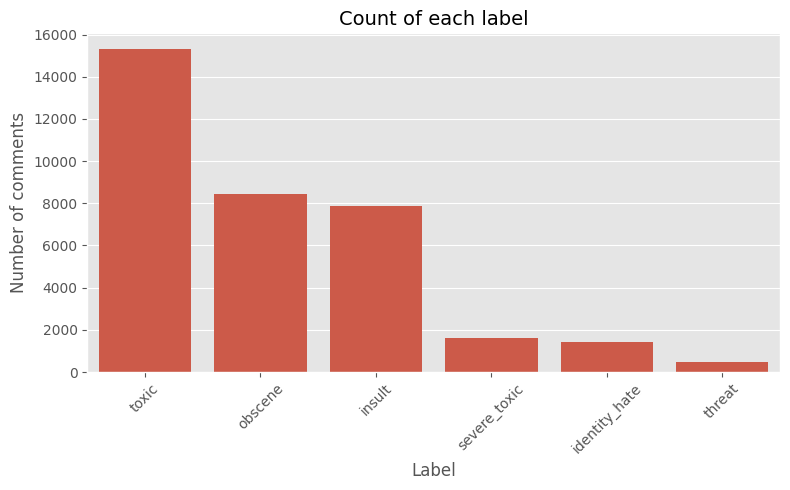

In [31]:
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Count of each label")
plt.ylabel("Number of comments")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
label_ratios = (label_counts / len(df)).sort_values(ascending=False)
print("Label ratios (fraction of dataset):")
print(label_ratios)

Label ratios (fraction of dataset):
toxic            0.095844
obscene          0.052948
insult           0.049364
severe_toxic     0.009996
identity_hate    0.008805
threat           0.002996
dtype: float64


### Note on label imbalance

The label distribution is very skewed. Some labels like `toxic` are relatively frequent,
while others such as `severe_toxic`, `threat` or `identity_hate` are rare.

This has a few consequences for the next phases of the project:

- A simple accuracy score will be misleading.
- The model may focus on the frequent labels and almost ignore the rare ones.
- Metrics for rare labels will be noisy, especially on a small validation set.

Later, during training, I will need to:
- Track per-label metrics (F1, precision, recall).
- Consider using class weights, focal loss or some form of oversampling for rare labels.
- Tune thresholds per label instead of using a single 0.5 cut-off.

### How many labels per comment?

For each comment, we can count how many labels are active (0 to 6).

In [33]:
df["num_labels"] = df[label_cols].sum(axis=1)

label_combo_counts = df["num_labels"].value_counts().sort_index()
label_combo_counts

num_labels
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64

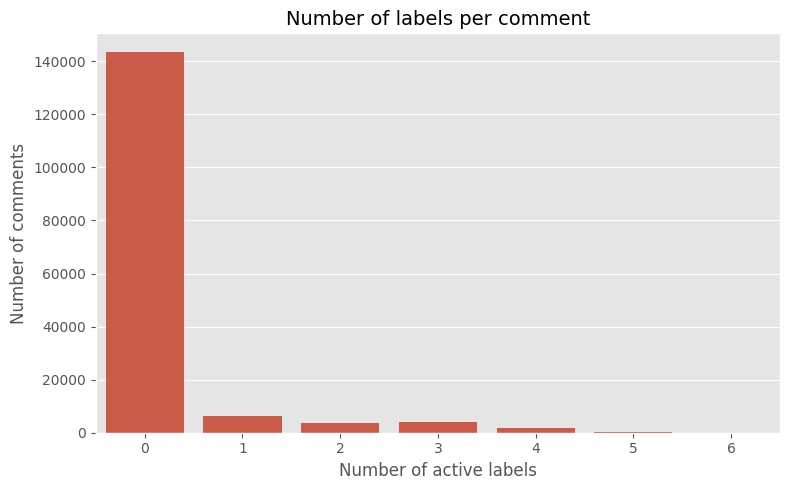

In [34]:
plt.figure(figsize=(8, 5))
sns.barplot(x=label_combo_counts.index, y=label_combo_counts.values)
plt.title("Number of labels per comment")
plt.xlabel("Number of active labels")
plt.ylabel("Number of comments")
plt.tight_layout()
plt.show()

### Correlation between labels

Just to see if some labels tend to appear together.

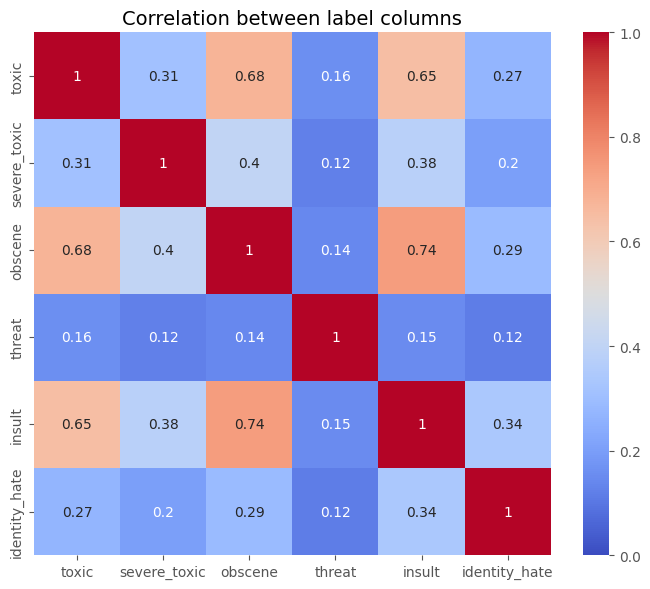

In [35]:
corr = df[label_cols].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Correlation between label columns")
plt.tight_layout()
plt.show()

## 5. Text length analysis

It's useful to know how long the comments are.  
This helps decide on a maximum sequence length for the model later.

In [36]:
df["text_length"] = df["comment_text"].astype(str).str.len()

df["text_length"].describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64

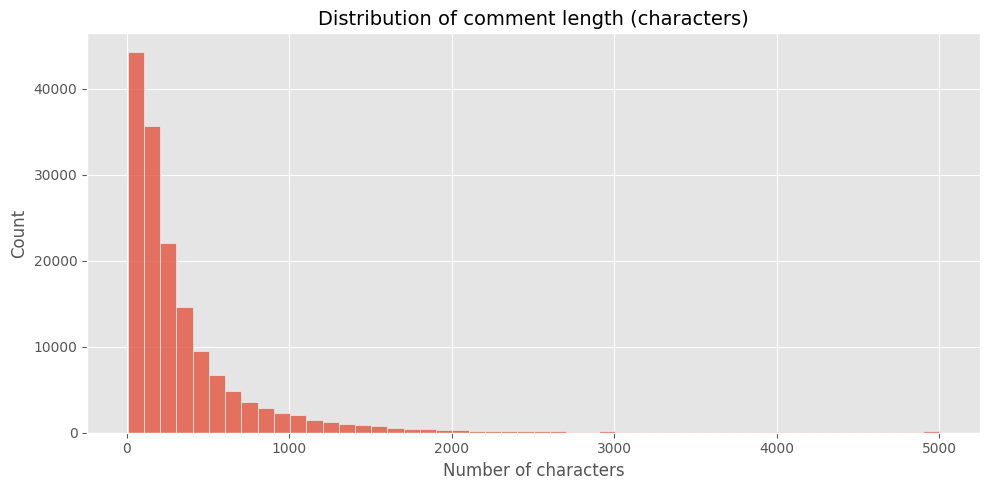

In [37]:
plt.figure(figsize=(10, 5))
sns.histplot(df["text_length"], bins=50)
plt.title("Distribution of comment length (characters)")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Sometimes the long tail can hide the structure.  
Let's also look at the distribution with a lower cap (e.g. <= 1000 chars).

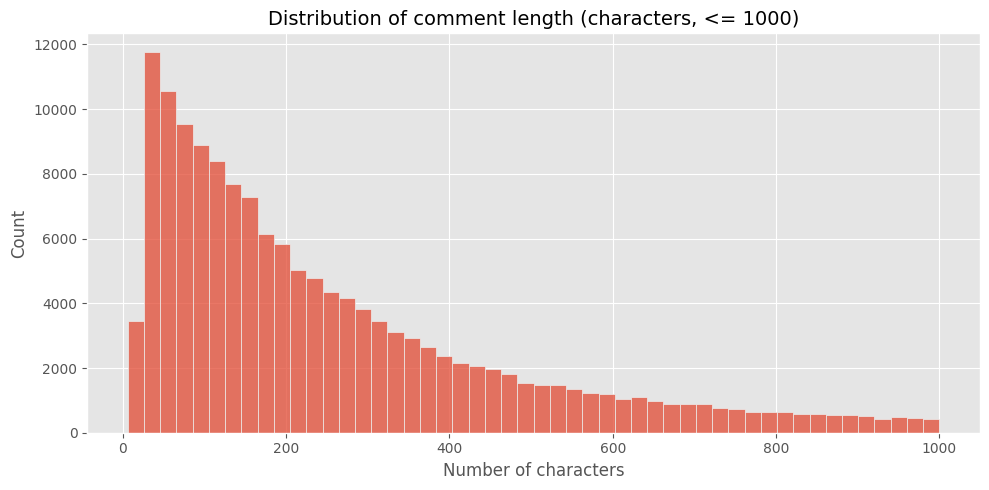

In [38]:
max_len = 1000
subset = df[df["text_length"] <= max_len]

plt.figure(figsize=(10, 5))
sns.histplot(subset["text_length"], bins=50)
plt.title(f"Distribution of comment length (characters, <= {max_len})")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We can also compare length distributions between toxic and non-toxic,
using the main `toxic` label as a simple example.

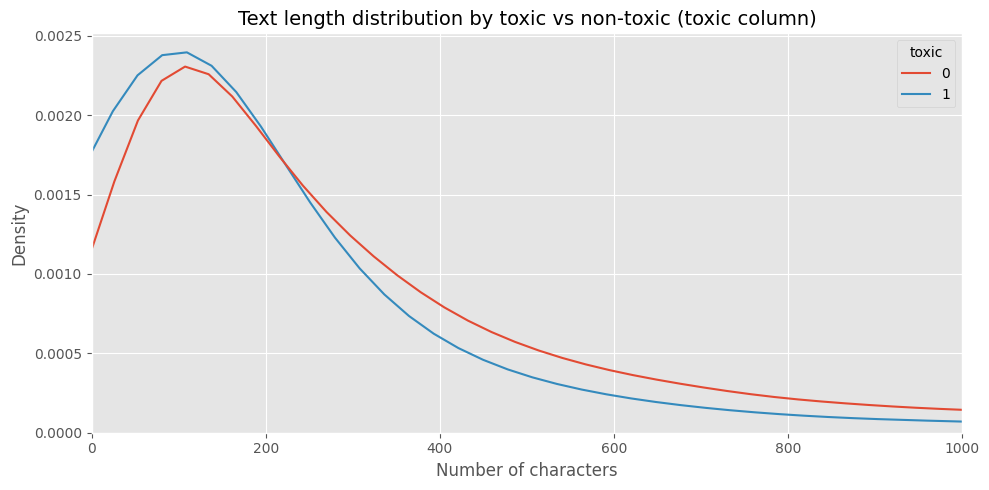

In [39]:
plt.figure(figsize=(10, 5))
sns.kdeplot(
    data=df,
    x="text_length",
    hue="toxic",
    common_norm=False,
    bw_adjust=1.2,
)
plt.xlim(0, 1000)  # limit for readability
plt.title("Text length distribution by toxic vs non-toxic (toxic column)")
plt.xlabel("Number of characters")
plt.tight_layout()
plt.show()

## 6. Light text cleaning

For Transformer-based models, it's usually better to keep:
- punctuation
- casing (unless using a cased model)

But we still want to remove:
- line breaks
- repeated spaces
- raw URLs
- obvious HTML tags

We'll create a `comment_clean` column and leave the original as is.

In [40]:
url_pattern = re.compile(r"http\S+|www\.\S+")
html_tag_pattern = re.compile(r"<.*?>")

def clean_text(text: str) -> str:
    # Make sure input is a string
    if not isinstance(text, str):
        text = str(text)

    # Remove URLs
    text = url_pattern.sub("", text)

    # Remove simple HTML tags
    text = html_tag_pattern.sub("", text)

    # Replace line breaks and tabs with spaces
    text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ")

    # Collapse multiple spaces into one
    text = re.sub(r"\s+", " ", text)

    # Strip leading/trailing spaces
    text = text.strip()

    return text

# Apply cleaning
df["comment_clean"] = df["comment_text"].apply(clean_text)

# Quick check: original vs cleaned for a few rows
df[["comment_text", "comment_clean"]].head(5)

,comment_text,comment_clean
0,Explanation\nWhy the edits made under my usern...,Explanation Why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It...","Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ...",""" More I can't make any real suggestions on im..."
4,"You, sir, are my hero. Any chance you remember...","You, sir, are my hero. Any chance you remember..."


Check if cleaning introduced any empty strings.

In [41]:
empty_mask = df["comment_clean"].str.len() == 0
print("Number of empty cleaned comments:", empty_mask.sum())

# If needed, we could drop them:
df = df[~empty_mask].reset_index(drop=True)

Number of empty cleaned comments: 8


## 7. Final dataset structure

At this point we have:
- `id`
- `comment_text`  (raw)
- `comment_clean` (cleaned)
- label columns (multi-label)
- helper columns: `num_labels`, `text_length`

Let's reorder the columns for clarity.

In [42]:
ordered_cols = (
    ["id", "comment_text", "comment_clean", "text_length", "num_labels"]
    + label_cols
)

df = df[ordered_cols]
df.head()

,id,comment_text,comment_clean,text_length,num_labels,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,Explanation Why the edits made under my userna...,264,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,D'aww! He matches this background colour I'm s...,112,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...","Hey man, I'm really not trying to edit war. It...",233,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",""" More I can't make any real suggestions on im...",622,0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...","You, sir, are my hero. Any chance you remember...",67,0,0,0,0,0,0,0


## 8. Train / validation split (optional)

For deep learning, it is handy to split now and reuse the same split later.
Here we do a simple random split.  
Multi-label stratification is more complicated, so we keep it simple for now.

If you really need stratification, you can:
- stratify on a simpler indicator like `any_toxic = (num_labels > 0)`
- or use a dedicated multi-label stratification library.

### Train / validation split – remarks

For now, I use a simple 90/10 train/validation split.

To keep at least a basic balance between "toxic" and "non-toxic", I create a
binary indicator `any_label` (1 = at least one toxic label, 0 = no label) and
use it to stratify the split.

This is **not** a perfect solution for a multi-label problem:

- The split is balanced only on "has any label" vs "no label".
- The rare labels (e.g. `threat`, `identity_hate`) may still end up with very
  few examples in the validation set.
- As a result, metrics for these labels will be unstable.

For a more robust setup later, I could:
- Use an iterative multi-label stratification method.
- Increase the validation size a bit (e.g. 15–20%) to have more rare examples.
- Or validate with cross-validation instead of a single split.

For now, I keep this simple split and just keep its limitations in mind.


In [43]:
from sklearn.model_selection import train_test_split

# Example: simple binary indicator for "at least one toxic label"
df["any_label"] = (df[label_cols].sum(axis=1) > 0).astype(int)

train_df, valid_df = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_STATE,
    stratify=df["any_label"],  # simple stratification
)

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)

# Compare label sums in train vs valid
print("\nLabel counts in TRAIN:")
print(train_df[label_cols].sum())

print("\nLabel counts in VALID:")
print(valid_df[label_cols].sum())

print("\nLabel ratios in TRAIN:")
print((train_df[label_cols].sum() / len(train_df)).round(6))

print("\nLabel ratios in VALID:")
print((valid_df[label_cols].sum() / len(valid_df)).round(6))


# Drop helper column from saved data if you don't need it
train_df = train_df.drop(columns=["any_label"])
valid_df = valid_df.drop(columns=["any_label"])
df = df.drop(columns=["any_label"])

Train shape: (143606, 12)
Valid shape: (15957, 12)

Label counts in TRAIN:
toxic            13769
severe_toxic      1452
obscene           7623
threat             436
insult            7099
identity_hate     1273
dtype: int64

Label counts in VALID:
toxic            1525
severe_toxic      143
obscene           826
threat             42
insult            778
identity_hate     132
dtype: int64

Label ratios in TRAIN:
toxic            0.095880
severe_toxic     0.010111
obscene          0.053083
threat           0.003036
insult           0.049434
identity_hate    0.008865
dtype: float64

Label ratios in VALID:
toxic            0.095569
severe_toxic     0.008962
obscene          0.051764
threat           0.002632
insult           0.048756
identity_hate    0.008272
dtype: float64


## 9. Save cleaned data

We save:
- full cleaned dataset
- train split
- validation split

in a `processed` subdirectory (create it if needed).

In [ ]:
OUTPUT_DIR = "./data/processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

full_path_csv = os.path.join(OUTPUT_DIR, "train_clean_full.csv")
train_path_csv = os.path.join(OUTPUT_DIR, "train_clean.csv")
valid_path_csv = os.path.join(OUTPUT_DIR, "valid_clean.csv")

df.to_csv(full_path_csv, index=False)
train_df.to_csv(train_path_csv, index=False)
valid_df.to_csv(valid_path_csv, index=False)

print("Saved:")
print(" -", full_path_csv)
print(" -", train_path_csv)
print(" -", valid_path_csv)

# Optional: also save as Parquet (faster to load, useful for large data)
#full_path_parquet = os.path.join(OUTPUT_DIR, "train_clean_full.parquet")
#df.to_parquet(full_path_parquet, index=False)
#print(" -", full_path_parquet)

Saved:
 - ./data/processed\train_clean_full.csv
 - ./data/processed\train_clean.csv
 - ./data/processed\valid_clean.csv
 - ./data/processed\train_clean_full.parquet


## 10. Quick recap (for myself)

- Loaded the original Jigsaw toxic comment dataset.
- Checked basic info and missing values.
- Looked at label counts, number of labels per comment,
  and correlation between labels (multi-label behavior).
- Explored text length distribution and compared toxic vs non-toxic comments.
- Applied a light cleaning:
  - removed URLs
  - removed basic HTML
  - removed line breaks / tabs
  - collapsed multiple spaces
- Created:
  - `comment_clean` (cleaned text)
  - `num_labels` and `text_length` helper columns
- Performed a train/validation split (10% valid) with a simple stratification
  based on "any toxic label".
- Saved everything in `./data/processed/` for the modeling notebook.

Next step will be to build and train the deep learning model
(e.g. a Transformer fine-tuned on `comment_clean` with the 6 labels).


A few caveats I need to remember for the modeling phase:

- The labels are very imbalanced. Some categories are rare and will need special
  care during training (class weights, focal loss, oversampling or careful
  threshold tuning).
- The train/validation split is only stratified on "has any label". This is not
  a true multi-label stratification. Rare labels may be under-represented in the
  validation set, so their metrics should be interpreted with caution.
- The text cleaning is intentionally light. This is fine for Transformer models,
  but if I switch to a different architecture (e.g. classical ML with TF-IDF),
  I may want a stronger normalization and possibly lemmatization/stopword
  removal.

These points are not blocking for data preparation but are important to keep in
mind when I design and evaluate the model.
